##### Imports & setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Feature names (without linear features):
feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std', 'cusum', 'IPR10',
                 'kurtosis', 'MPR40_5', 'MPR20_10', 'maxSlope', 'medianAbsDev', 'medianBRP10',
                 'percentAmplitude', 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

## Data preparation

### Getting data

In [2]:
# The following paths should be changed accordingly. The data can be saved in a csv from the clean_data.ipynb notebook.
positive_g = pd.read_csv('../../data/one_year_data/positive_g.csv', index_col=0)
positive_r = pd.read_csv('../../data/one_year_data/positive_r.csv', index_col=0)
negative_g = pd.read_csv('../../data/one_year_data/negative_g.csv', index_col=0)
negative_r = pd.read_csv('../../data/one_year_data/negative_r.csv', index_col=0)

# Adding labels for each class:
positive_g['class'] = 'positive'
positive_r['class'] = 'positive'
negative_g['class'] = 'negative'
negative_r['class'] = 'negative'

# Normalizing features:
g_set = pd.concat([positive_g, negative_g]) # Grouping positive & negative together so that they are then normalized the same way.
g_set = normalize(g_set[feature_names], axis=0)
positive_g[feature_names] = g_set[:len(positive_g)]
negative_g[feature_names] = g_set[len(positive_g):]

### Organizing samples & train-test split

Ignoring the two filters, we have two main datasets:
1. The positive class, which contains alerts form known magnetic cataclysmic variable stars.
2. The negative class, which contains alerts from objects that are not in the positive class or that are unknown.

These two classes live in a ~20 dimensional feature space, and we hope that the positive class is somewhat clustered in that space. If that is the case, the nearest neighbors of positive class objects should also be of the positive class.

Since the positive class is poorly represented compared to the negative one, we first try here the nearest neighbors algorithm on a dataset composed of an equal number of alerts from the positive and negative classes. Then, the number of alerts from the negative class is increased by a factor two and then three.

**The train and test samples should contain different objects**

In [3]:
# IDs of unique objects in each class:
positive_g_Ids = np.unique(positive_g['objectId'])
positive_r_Ids = np.unique(positive_r['objectId'])
negative_g_Ids = np.unique(negative_g['objectId'])
negative_r_Ids = np.unique(negative_r['objectId'])

# Number of unique objects in each class:
print(f'There are {len(positive_g_Ids)} unique objects in the positive class (g filter).')
print(f'There are {len(positive_r_Ids)} unique objects in the positive class (r filter).')
print(f'There are {len(negative_g_Ids)} unique objects in the negative class (g filter).')
print(f'There are {len(negative_r_Ids)} unique objects in the negative class (r filter).')

There are 78 unique objects in the positive class (g filter).
There are 78 unique objects in the positive class (r filter).
There are 363 unique objects in the negative class (g filter).
There are 359 unique objects in the negative class (r filter).


In [4]:
np.random.seed(42)

# Splitting the positive class with 70% of objects in the train set and 30% in the test:
positive_g_Ids_train, positive_g_Ids_test = train_test_split(positive_g_Ids, train_size=.7)
positive_g_train = positive_g[positive_g['objectId'].isin(positive_g_Ids_train)]
positive_g_test = positive_g[positive_g['objectId'].isin(positive_g_Ids_test)]

# Splitting the negative class with 70% of objects in the train set and 30% in the test:
negative_g_Ids_train, negative_g_Ids_test = train_test_split(negative_g_Ids, train_size=.7)
negative_g_train = negative_g[negative_g['objectId'].isin(negative_g_Ids_train)]
negative_g_test = negative_g[negative_g['objectId'].isin(negative_g_Ids_test)]

# Sampling x alerts in the negative train set (x = nb of alerts in the positive train set):
negative_g_train_indices1 = np.random.choice(negative_g_train.index, len(positive_g_train), replace=False)
negative_g_train1 = negative_g_train.loc[negative_g_train_indices1]

# Sampling 2x alerts in the negative train set
negative_g_train_indices2 = np.random.choice(negative_g_train.index, 2*len(positive_g_train), replace=False)
negative_g_train2 = negative_g_train.loc[negative_g_train_indices2]

# Sampling 3x alerts in the negative train set
negative_g_train_indices3 = np.random.choice(negative_g_train.index, 3*len(positive_g_train), replace=False)
negative_g_train3 = negative_g_train.loc[negative_g_train_indices3]

# Assembling the final train sets:
train_g1 = pd.concat([positive_g_train, negative_g_train1]).reset_index()
train_g2 = pd.concat([positive_g_train, negative_g_train2]).reset_index()
train_g3 = pd.concat([positive_g_train, negative_g_train3]).reset_index()
train_g4 = pd.concat([positive_g_train, negative_g_train]).reset_index() # Using the whole negative class

## Finding nearest neighbors

### Wrapper

In [5]:
def NN_wrapper(train: pd.DataFrame, test: pd.DataFrame, **NN_kwargs) -> tuple[pd.DataFrame, float]:
    """Wrapper for the NearestNeighbors class from scikit-learn.
    This function takes the training and testing sets and prints out the propotion of neighbors that are of the positive and negative class.

    Args:
        train (pd.DataFrame): Training set (a combination of positive and negative class objects).
        test (pd.DataFrame): Testing set (positive class objects only, and different from those of the training set).
        NN_kwargs: Keyword arguments for the NearestNeighbors class from scickit-learn.

    Returns:
        tuple (neighbors, accuracy):
            - neighbors (pd.DataFrame): The neighbors of the test set objects.
            - accuracy (float): The ratio of neighbors that are of the positive class.
    """

    default_kwargs: dict = {}
    default_kwargs.update(NN_kwargs)

    # Fitting the NearestNeighbors model:
    neigh = NearestNeighbors(**default_kwargs)
    neigh.fit(train[feature_names])

    # Finding the nearest neighbors of the test set objects:
    neighbors_indices = neigh.kneighbors(test[feature_names], return_distance=False)
    neighbors = train.loc[neighbors_indices.flatten()]

    # Calculating the accuracy of the model:
    accuracy = (neighbors['class'] == 'positive').sum() / len(neighbors)

    return neighbors, accuracy

##### Work In Progress Zone

In [6]:
# function to extract distance and number of points in the calculated features to try and see if there is a correlation:s
def temp(train, test):
    neighbors = pd.DataFrame(columns=['target', 'nb_of_points_target', 'neighbor', 'nb_of_points_neighbor', 'neighbor_index', 'distance', 'class'])
    neighbors['target'] = test['objectId']
    neighbors['nb_of_points_target'] = test['nb_of_points']

    # Fitting the NearestNeighbors model:
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(train[feature_names])

    # Finding the nearest neighbors of the test set objects:
    neighbors_distance, neighbors_indices = neigh.kneighbors(test[feature_names])

    neighbors['neighbor'] = [train['objectId'][i].values[0] for i in neighbors_indices]
    neighbors['nb_of_points_neighbor'] = [train['nb_of_points'][i].values[0] for i in neighbors_indices]
    neighbors['neighbor_index'] = neighbors_indices
    neighbors['distance'] = neighbors_distance
    neighbors['class'] = [train['class'][i].values[0] for i in neighbors_indices]

    neighbors.sort_values('nb_of_points_target', inplace=True)
    return neighbors

In [7]:
neighbors = temp(train_g1, positive_g_test)
neighbors

,target,nb_of_points_target,neighbor,nb_of_points_neighbor,neighbor_index,distance,class
4,ZTF18aditqga,18,ZTF19acbzasn,97,63,0.027083,negative
0,ZTF18aajbbtc,26,ZTF19abqysrd,110,99,0.040891,negative
35,ZTF18adjefml,26,ZTF17aabxlrc,124,5,0.044623,positive
22,ZTF18abmqugk,29,ZTF18adkvdia,50,83,0.036506,negative
6,ZTF18abvpodm,68,ZTF18acuexzs,36,4,0.082659,positive
64,ZTF18aabjqhl,71,ZTF19abqysrd,110,99,0.021442,negative
30,ZTF17aabtdus,77,ZTF18abmodvj,73,69,0.026915,negative
62,ZTF17aabdpti,78,ZTF18aayxqoc,252,38,0.049546,positive
31,ZTF19aadoqcb,84,ZTF18abmeesl,131,7,0.026649,positive
43,ZTF18aceqsfw,95,ZTF19aaaonhi,111,22,0.078278,positive


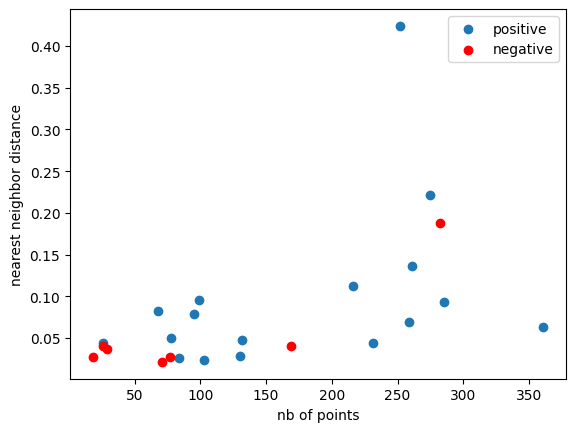

In [8]:
plt.scatter(neighbors[neighbors['class'] == 'positive']['nb_of_points_target'], neighbors[neighbors['class'] == 'positive']['distance'], label='positive')
plt.scatter(neighbors[neighbors['class'] == 'negative']['nb_of_points_target'], neighbors[neighbors['class'] == 'negative']['distance'], c='r', label='negative')
plt.legend()
plt.xlabel('nb of points')
plt.ylabel('nearest neighbor distance');

### Nearest neighbors accuracy results

In [9]:
def explore_params(train, test):
    K: list[int] = [1, 5, 10, 15, 20]
    leaf_sizes: list[int] = [2, 5, 10, 20, 30, 40, 50]
    algorithms: list[str] = ['ball_tree', 'kd_tree', 'brute']

    max_accuracy: dict = {'accuracy': 0, 'algo': 'none', 'k': 0, 'leaf_size': 0}

    for algo in algorithms:
        print('\n'+algo+':')
        for k in K:
            print(f'{k=}:')
            for leaf_size in leaf_sizes:
                print(f'{leaf_size=}:')
                _, accuracy = NN_wrapper(train, test, n_neighbors=k, algorithm=algo, leaf_size=leaf_size)
                if accuracy > max_accuracy['accuracy']:
                    max_accuracy = {'accuracy': accuracy, 'algo': algo, 'k': k, 'leaf_size': leaf_size}
                print(accuracy)

    print(f'{max_accuracy=}')
    
    return

#### Train sample positive-negative ratio: 1-1

In [10]:
explore_params(train_g1, positive_g_test)


ball_tree:
k=1:
leaf_size=2:
0.7083333333333334
leaf_size=5:
0.7083333333333334
leaf_size=10:
0.7083333333333334
leaf_size=20:
0.7083333333333334
leaf_size=30:
0.7083333333333334
leaf_size=40:
0.7083333333333334
leaf_size=50:
0.7083333333333334
k=5:
leaf_size=2:
0.6666666666666666
leaf_size=5:
0.6666666666666666
leaf_size=10:
0.6666666666666666
leaf_size=20:
0.6666666666666666
leaf_size=30:
0.6666666666666666
leaf_size=40:
0.6666666666666666
leaf_size=50:
0.6666666666666666
k=10:
leaf_size=2:
0.6125
leaf_size=5:
0.6125
leaf_size=10:
0.6125
leaf_size=20:
0.6125
leaf_size=30:
0.6125
leaf_size=40:
0.6125
leaf_size=50:
0.6125
k=15:
leaf_size=2:
0.5944444444444444
leaf_size=5:
0.5944444444444444
leaf_size=10:
0.5944444444444444
leaf_size=20:
0.5944444444444444
leaf_size=30:
0.5944444444444444
leaf_size=40:
0.5944444444444444
leaf_size=50:
0.5944444444444444
k=20:
leaf_size=2:
0.60625
leaf_size=5:
0.60625
leaf_size=10:
0.60625
leaf_size=20:
0.60625
leaf_size=30:
0.60625
leaf_size=40:
0.6062

#### Train sample positive-negative ratio: 1-2

In [11]:
explore_params(train_g2, positive_g_test)


ball_tree:
k=1:
leaf_size=2:
0.7083333333333334
leaf_size=5:
0.7083333333333334
leaf_size=10:
0.7083333333333334
leaf_size=20:
0.7083333333333334
leaf_size=30:
0.7083333333333334
leaf_size=40:
0.7083333333333334
leaf_size=50:
0.7083333333333334
k=5:
leaf_size=2:
0.625
leaf_size=5:
0.625
leaf_size=10:
0.625
leaf_size=20:
0.625
leaf_size=30:
0.625
leaf_size=40:
0.625
leaf_size=50:
0.625
k=10:
leaf_size=2:
0.5291666666666667
leaf_size=5:
0.5291666666666667
leaf_size=10:
0.5291666666666667
leaf_size=20:
0.5291666666666667
leaf_size=30:
0.5291666666666667
leaf_size=40:
0.5291666666666667
leaf_size=50:
0.5291666666666667
k=15:
leaf_size=2:
0.5194444444444445
leaf_size=5:
0.5194444444444445
leaf_size=10:
0.5194444444444445
leaf_size=20:
0.5194444444444445
leaf_size=30:
0.5194444444444445
leaf_size=40:
0.5194444444444445
leaf_size=50:
0.5194444444444445
k=20:
leaf_size=2:
0.5
leaf_size=5:
0.5
leaf_size=10:
0.5
leaf_size=20:
0.5
leaf_size=30:
0.5
leaf_size=40:
0.5
leaf_size=50:
0.5

kd_tree:
k

#### Train sample positive-negative ratio: 1-3

In [12]:
explore_params(train_g3, positive_g_test);


ball_tree:
k=1:
leaf_size=2:
0.6666666666666666
leaf_size=5:
0.6666666666666666
leaf_size=10:
0.6666666666666666
leaf_size=20:
0.6666666666666666
leaf_size=30:
0.6666666666666666
leaf_size=40:
0.6666666666666666
leaf_size=50:
0.6666666666666666
k=5:
leaf_size=2:
0.49166666666666664
leaf_size=5:
0.49166666666666664
leaf_size=10:
0.49166666666666664
leaf_size=20:
0.49166666666666664
leaf_size=30:
0.49166666666666664
leaf_size=40:
0.49166666666666664
leaf_size=50:
0.49166666666666664
k=10:
leaf_size=2:
0.4375
leaf_size=5:
0.4375
leaf_size=10:
0.4375
leaf_size=20:
0.4375
leaf_size=30:
0.4375
leaf_size=40:
0.4375
leaf_size=50:
0.4375
k=15:
leaf_size=2:
0.4305555555555556
leaf_size=5:
0.4305555555555556
leaf_size=10:
0.4305555555555556
leaf_size=20:
0.4305555555555556
leaf_size=30:
0.4305555555555556
leaf_size=40:
0.4305555555555556
leaf_size=50:
0.4305555555555556
k=20:
leaf_size=2:
0.39791666666666664
leaf_size=5:
0.39791666666666664
leaf_size=10:
0.39791666666666664
leaf_size=20:
0.39791

#### Train sample positive-negative ratio: 1-full

In [13]:
explore_params(train_g4, positive_g_test)


ball_tree:
k=1:
leaf_size=2:
0.6666666666666666
leaf_size=5:
0.6666666666666666
leaf_size=10:
0.6666666666666666
leaf_size=20:
0.6666666666666666
leaf_size=30:
0.6666666666666666
leaf_size=40:
0.6666666666666666
leaf_size=50:
0.6666666666666666
k=5:
leaf_size=2:
0.44166666666666665
leaf_size=5:
0.44166666666666665
leaf_size=10:
0.44166666666666665
leaf_size=20:
0.44166666666666665
leaf_size=30:
0.44166666666666665
leaf_size=40:
0.44166666666666665
leaf_size=50:
0.44166666666666665
k=10:
leaf_size=2:
0.36666666666666664
leaf_size=5:
0.36666666666666664
leaf_size=10:
0.36666666666666664
leaf_size=20:
0.36666666666666664
leaf_size=30:
0.36666666666666664
leaf_size=40:
0.36666666666666664
leaf_size=50:
0.36666666666666664
k=15:
leaf_size=2:
0.3638888888888889
leaf_size=5:
0.3638888888888889
leaf_size=10:
0.3638888888888889
leaf_size=20:
0.3638888888888889
leaf_size=30:
0.3638888888888889
leaf_size=40:
0.3638888888888889
leaf_size=50:
0.3638888888888889
k=20:
leaf_size=2:
0.339583333333333